# Setup

In [1]:
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from pathlib import Path

import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO, RenyiELBO, Predictive
from pyro.optim import Adam

import pandas as pd
import plotnine as p9

import pyro_vmm

import importlib
importlib.reload(pyro_vmm)

<module 'pyro_vmm' from '/home/david/pyro_vmm/pyro_vmm.py'>

In [2]:
import scanpy as sc

sc.set_figure_params(figsize=(5, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
#!pip3 install pyro-ppl pymde scvi-colab
#from scvi_colab import install
#install()
#import scvi
#adata = scvi.data.heart_cell_atlas_subsampled() # save_path=save_dir.name)
# adata.write_h5ad("/content/drive/MyDrive/scvi_data/heart_cell_atlas_subsampled.h5ad")

In [4]:
save_dir = Path("saved_models/")
save_dir.mkdir(exist_ok=True)

In [5]:
adata = sc.read_h5ad("heart_cell_atlas_subsampled.h5ad")

In [6]:
sc.pp.filter_genes(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4) # this is the seurat default normalization
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`. adata.X is the actual data.

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

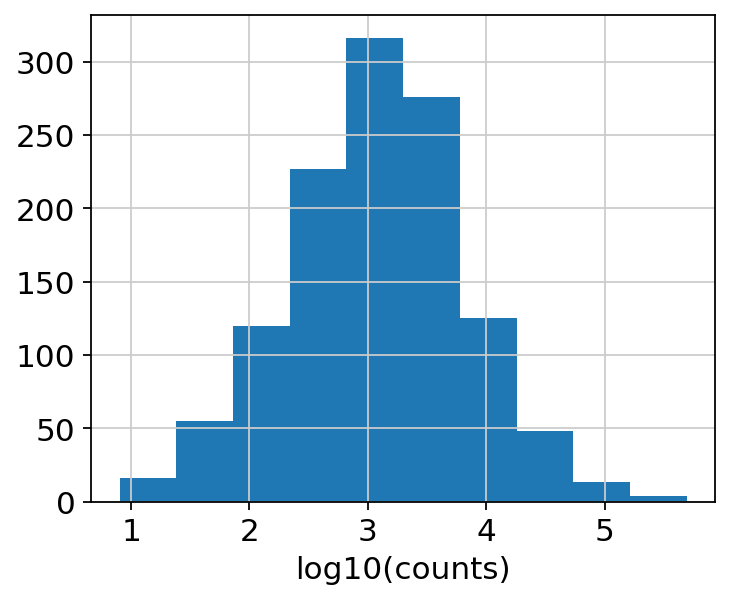

In [7]:
gene_sums = adata.layers["counts"].sum(0).A1
plt.hist(np.log10(gene_sums))
plt.xlabel("log10(counts)")
plt.show()

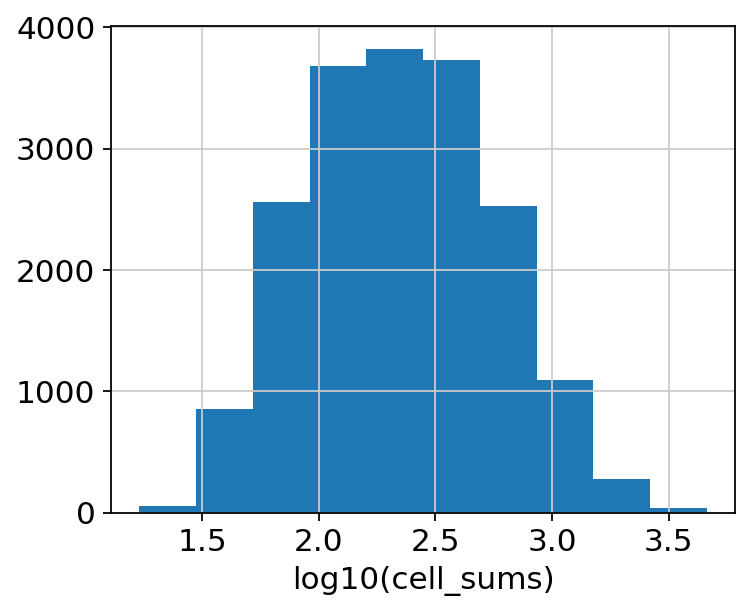

In [8]:
cell_sums = adata.layers["counts"].sum(1).A1
plt.hist(np.log10(cell_sums))
plt.xlabel("log10(cell_sums)")
plt.show()

# Thoughts on including covariates

If covariates (batch etc) are given to the encoder this allows the encoder to adapt its embedding so that these match across batches etc, i.e. the equivalent cells are projected to the same place in embedded space.

If covariates are given to the decoder this means there is no value to the VAE to encoding any info about batch in z, since that info is already available to the decoder to help with batch-specific reconstruction. Thus the decoder, analogously to the encoder, can reconstruct to the batch specific space. Note there is still no explicit cost to batch effects being present in z. The SCVI paper mentions the possibly of expliciting minimizing MMD (could also be OT distance presumably?) between batches, but that they haven't found this useful and that it would remove any real biological differences between batches (if bio covariates were part of x (z?) I think this concern is alleviated however?).

Note that whether covariates are given just to the first layer of the encoder (decoder) or injected at every layer is merely an architectural choice.

We might wish to explicitly include/protect some meaningful biological covariates in z (e.g. sex, age, disease status). I think the most natural option here is to include the _reconstruction_ of these in the decoder loss, but not include them as inputs to the encoder or the decoder. That way, if there is signal in the RNA-seq relating to the biological variation of interest, the encoder is encouraged to maintain that variation in z. If bio covariates are included in the encoder input AND decoder output, the model has an incentive to maintain this info in z _even if it doesn't relate to the expression_.

In [9]:
pyro.__version__

'1.9.1'

In [10]:
#assert pyro.__version__.startswith('1.8.6')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [11]:
# for loading and batching MNIST dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Code

In [12]:
cell_types = adata.obs['cell_type'].values # pandas categorical series

X = adata.layers["counts"]

X_train, X_test, cell_types_train, cell_types_test = train_test_split(adata.X, cell_types, test_size=0.2, random_state=42)

train_dataset = pyro_vmm.CSRDataset(X_train)
test_dataset = pyro_vmm.CSRDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

X_test_dense = np.asarray(X_test.todense()) # these are counts
test_x = X_test_dense / X_test_dense.sum(1, keepdims=True)
test_x = np.log(test_x * 1e4 + 1.)
test_x_torch = torch.tensor(test_x, device = device, dtype = torch.float)

X_train_dense = np.asarray(X_train.todense()) # these are counts
train_x = X_train_dense / X_train_dense.sum(1, keepdims=True)
train_x = np.log(train_x * 1e4 + 1.)
train_x_torch = torch.tensor(train_x, device = device, dtype = torch.float)


# Training



## Normal prior

In [13]:
svi, vae = pyro_vmm.init_vae(X_train, train_loader, device, hidden_dim = 50, K = 100, z_dim = 50, z_prior = "normal")

[epoch 000] average test loss: 288786.5422.0904
[epoch 005] average test loss: 11741.9059.3252
[epoch 010] average test loss: 9611.0810.8697
[epoch 015] average test loss: 8916.0242.9083
[epoch 020] average test loss: 8632.8319.8529
[epoch 025] average test loss: 8461.2783.2592
[epoch 030] average test loss: 8256.1338.1366
[epoch 035] average test loss: 7905.8320.6326
[epoch 040] average test loss: 7646.9740.6503
[epoch 045] average test loss: 7508.9224.1896
[epoch 050] average test loss: 7427.4661.8890
[epoch 055] average test loss: 7355.7602.5867
[epoch 060] average test loss: 7295.8485.6976
[epoch 065] average test loss: 7242.1613.6442
[epoch 070] average test loss: 7167.5539.9575
[epoch 075] average test loss: 7081.7604.1695
[epoch 080] average test loss: 7006.7608.5037
[epoch 085] average test loss: 6931.4144.6927
[epoch 090] average test loss: 6852.7527.5018
[epoch 095] average test loss: 6762.1566.0355
[epoch 100] average test loss: 6687.9135.0052
[epoch 105] average test loss: 

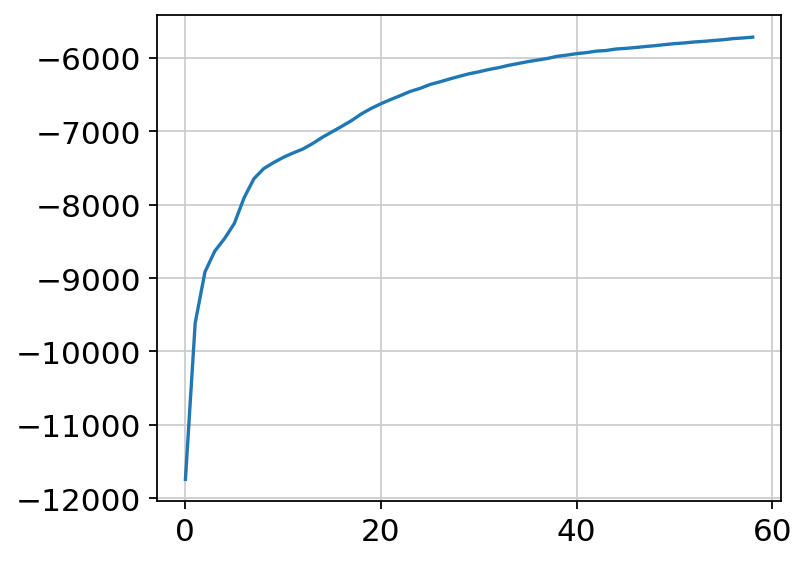

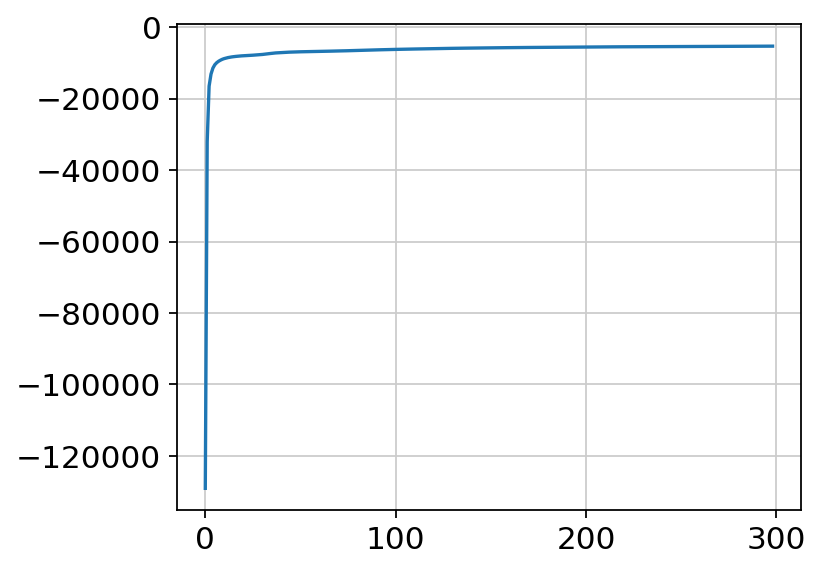

In [14]:
train_elbo, test_elbo = pyro_vmm.train_loop(svi, vae, train_loader, test_loader, device = device, num_epochs = 300)
plt.plot(test_elbo[1:]); plt.show()
plt.plot(train_elbo[1:]); plt.show()

In [15]:
pyro_vmm.estimate_marginal_likelihood(vae, test_x_torch) # reports ELBO and log_marginal_likelihood

(-2489764.541937498, -2487610.75)

In [17]:
z_loc, z_scale = vae.encoder(train_x_torch)

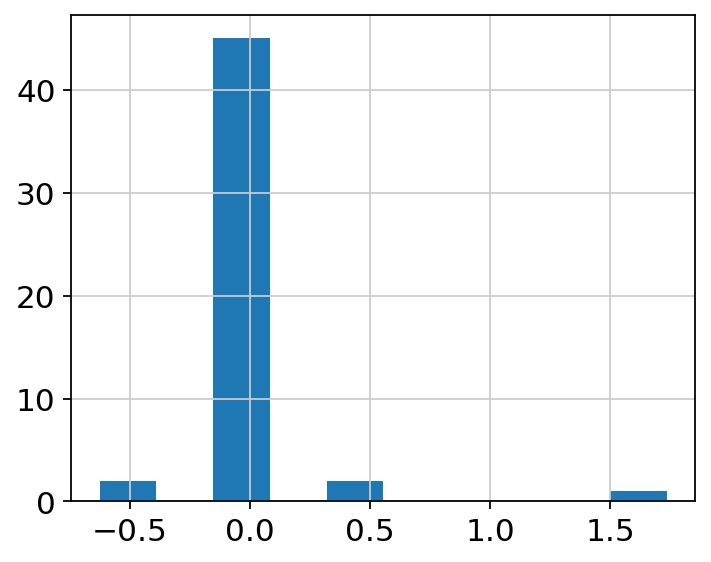

In [18]:
plt.hist(z_loc.mean(0).detach().cpu().numpy())
plt.show()

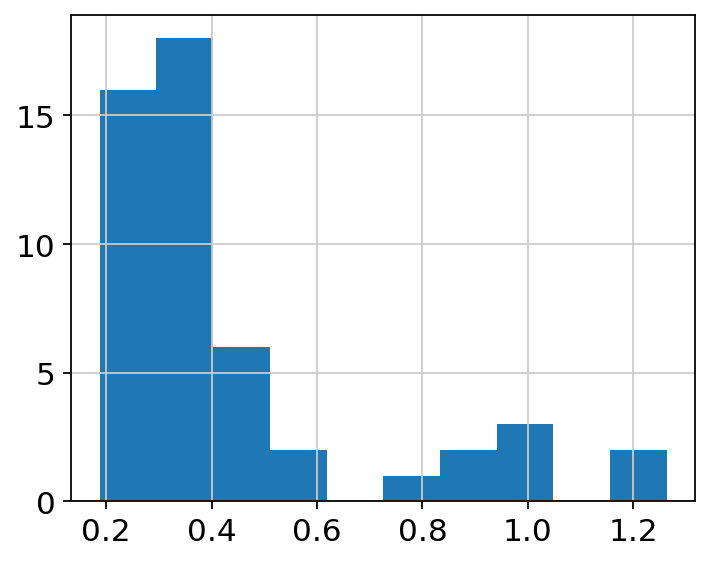

In [19]:
plt.hist(z_loc.std(0).detach().cpu().numpy())
plt.show()

In [20]:
anchor_embedder = pyro_vmm.AnchorEmbedder(z_loc.detach())

Jul 30 10:22:28 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:22:31 2024 Building RP forest with 16 trees
Tue Jul 30 22:22:33 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:22:41 PM: Computing quadratic initialization.


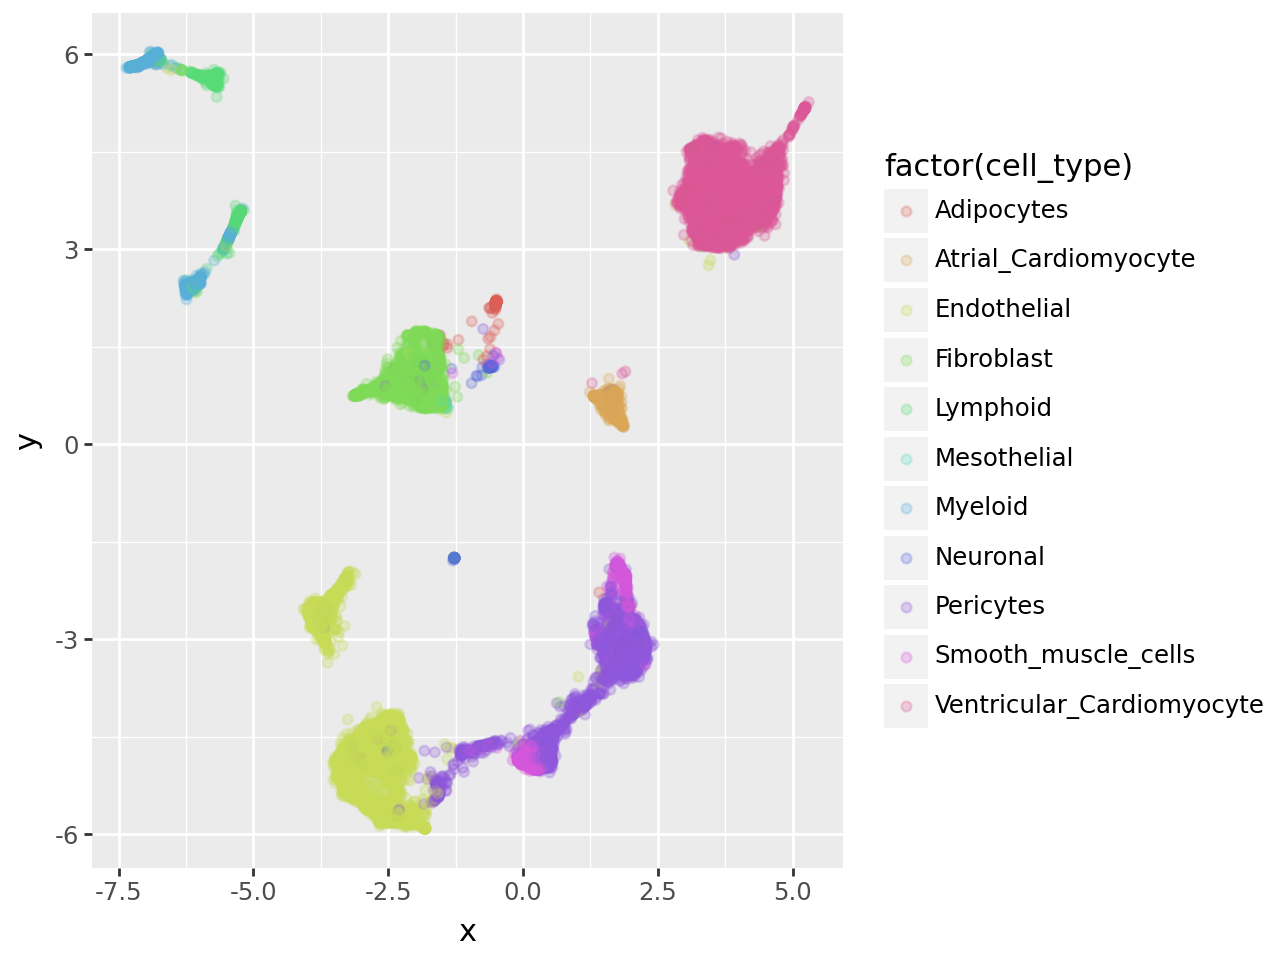

In [21]:
df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["cell_type"] = cell_types_train
p9.ggplot(df, p9.aes(x="x", y="y", color = "factor(cell_type)")) + \
 p9.geom_point(alpha = 0.25)

In [22]:
samples = torch.randn(3000, 50, device = device)
expression = vae.decoder(samples).exp()
z_loc_samp, _ = vae.encoder(expression) # encoder normalizes anyway

Jul 30 10:22:48 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:22:48 2024 Building RP forest with 17 trees
Tue Jul 30 22:22:48 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:22:51 PM: Fitting a anchored embedding into R^2, for a graph with 17912 items and 43881 edges.
Jul 30 10:22:51 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:22:51 PM: iteration 000 | distortion 1.216937 | residual norm 0.0141778 | step length 4180.95 | percent change 9.74196
Jul 30 10:22:51 PM: iteration 030 | distortion 0.075181 | residual norm 0.00149373 | step length 1 | percent change 0.125784
Jul 30 10:22:51 PM: iteration 060 | distortion 0.072724 | residual norm 0.000536704 | step length 1 | percent change 0.0168937
Jul 30 10:22:51 PM: iteration 090 | distortion 0.072123 | residual norm 0.000370726 | step length 1 | percent change 0.0855672
Jul 30 10:22:51 PM: iter

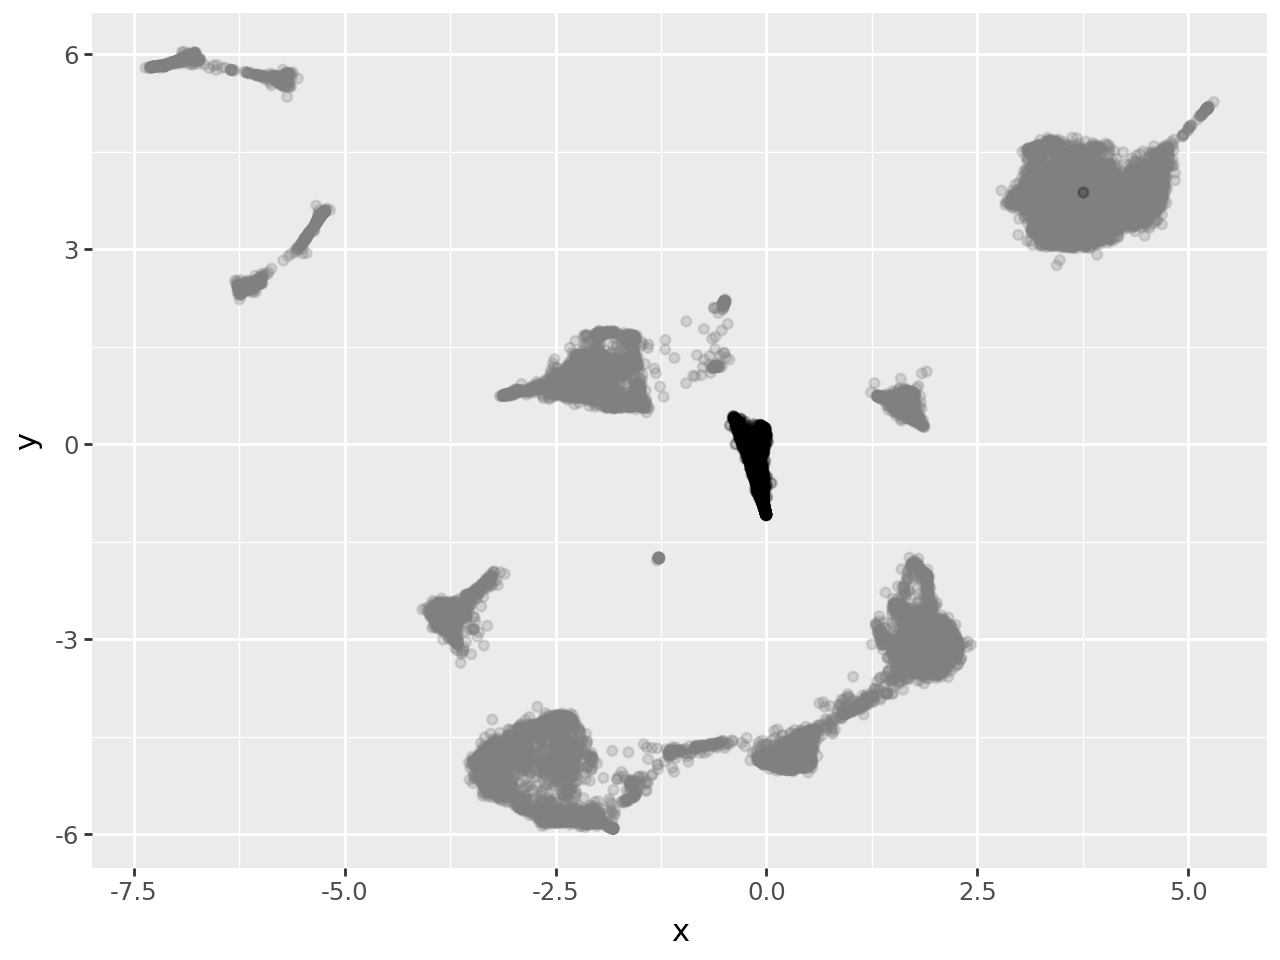

In [23]:
embedding = anchor_embedder.increment(z_loc_samp.detach())

df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["target"] = cell_types_train
df_mix = pd.DataFrame(embedding.numpy(), columns = ["x","y"])
p9.ggplot(df, p9.aes(x="x", y="y")) + \
 p9.geom_point(color = "gray", alpha = 0.25) + p9.geom_point(data = df_mix, color = "black", alpha = 0.25)

No overlap at all.

[epoch 000] average test loss: 7017.6553.1587
[epoch 005] average test loss: 5721.4108.3235
[epoch 010] average test loss: 5592.5790.5520
[epoch 015] average test loss: 5474.0038.7767
[epoch 020] average test loss: 5383.7403.9052
[epoch 025] average test loss: 5328.6331.2587
[epoch 030] average test loss: 5293.7041.3204
[epoch 035] average test loss: 5267.4718.3069
[epoch 040] average test loss: 5248.9944.3390
[epoch 045] average test loss: 5233.5121.4316
[epoch 050] average test loss: 5220.8926.7538
[epoch 055] average test loss: 5209.2463.6408
[epoch 060] average test loss: 5199.3431.3078
[epoch 065] average test loss: 5183.5161.7583
[epoch 070] average test loss: 5170.4704.8456
[epoch 075] average test loss: 5165.0652.3708
[epoch 080] average test loss: 5161.0011.5586
[epoch 085] average test loss: 5155.9835.4410
[epoch 090] average test loss: 5150.1248.3873
[epoch 095] average test loss: 5150.5550.9787


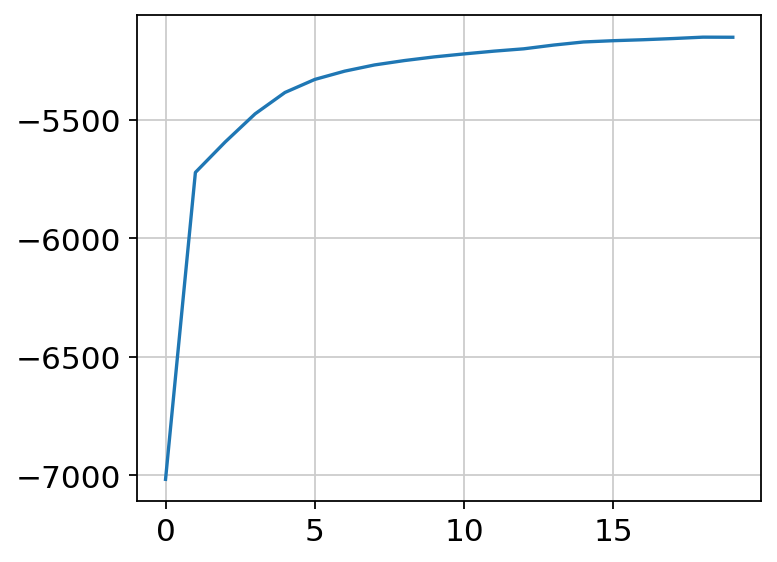

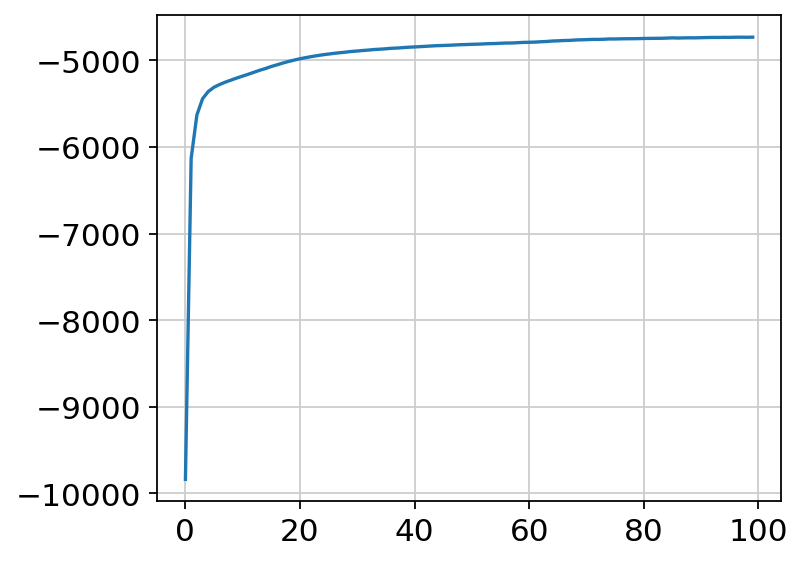

In [24]:
optimizer = Adam({"lr": 1e-02})

renyiVI = SVI(vae.model, vae.guide, optimizer, loss=RenyiELBO(num_particles = 10))

train_elbo, test_elbo = pyro_vmm.train_loop(renyiVI, vae, train_loader, test_loader, device, file_suffix="normal_renyiVI", num_epochs = 100)
plt.plot(test_elbo); plt.show()
plt.plot(train_elbo); plt.show()

In [25]:
pyro_vmm.estimate_marginal_likelihood(vae, test_x_torch)

(-1894068.3595312475, -1892451.0)

## Normal with learned mean/var

[epoch 000] average test loss: 408160.7885.9060
[epoch 005] average test loss: 15482.3799.9192
[epoch 010] average test loss: 9937.0916.37689
[epoch 015] average test loss: 8425.4532.5771
[epoch 020] average test loss: 7872.8301.9925
[epoch 025] average test loss: 7652.1392.1328
[epoch 030] average test loss: 7546.6780.2708
[epoch 035] average test loss: 7502.7106.8869
[epoch 040] average test loss: 7469.7463.8949
[epoch 045] average test loss: 7451.1940.3147
[epoch 050] average test loss: 7439.7773.5317
[epoch 055] average test loss: 7430.2684.7220
[epoch 060] average test loss: 7418.4996.5730
[epoch 065] average test loss: 7416.5474.5372
[epoch 070] average test loss: 7413.4695.4940
[epoch 075] average test loss: 7405.6498.9452
[epoch 080] average test loss: 7398.3608.6309
[epoch 085] average test loss: 7400.8846.2818
[epoch 090] average test loss: 7391.6929.6045
[epoch 095] average test loss: 7388.0162.3765
[epoch 100] average test loss: 7383.4424.7237
[epoch 105] average test loss:

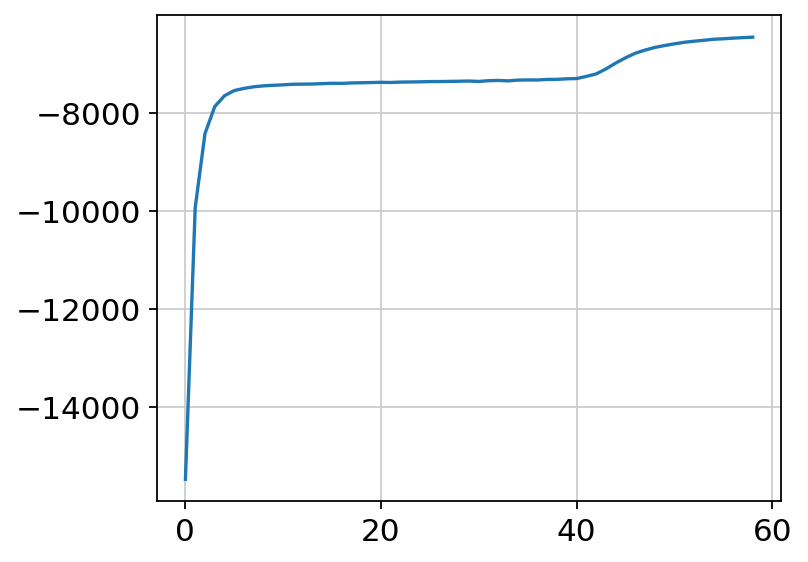

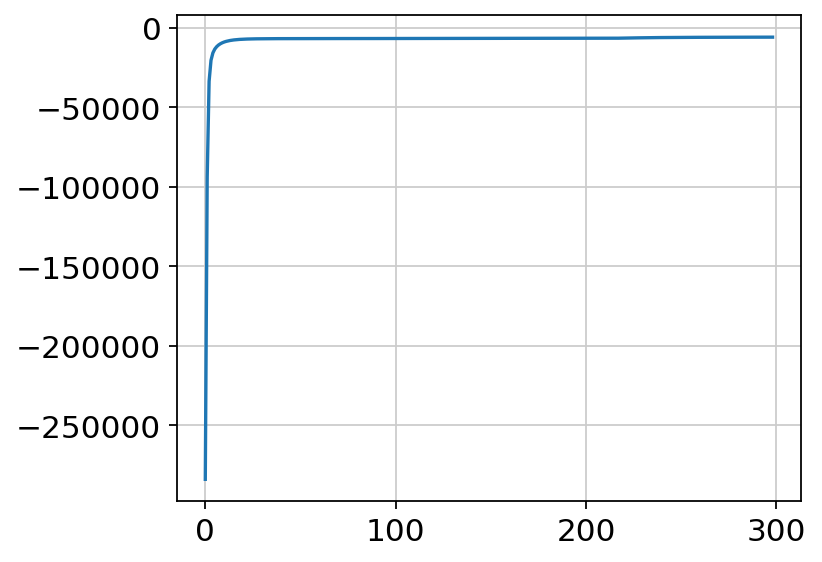

In [26]:
svi, vae_gmm1 = pyro_vmm.init_vae(X_train, train_loader, device, hidden_dim = 50, K = 1, z_dim = 50, z_prior = "gmm")

train_elbo, test_elbo = pyro_vmm.train_loop(svi, vae_gmm1, train_loader, test_loader, device)
plt.plot(test_elbo[1:]); plt.show()
plt.plot(train_elbo[1:]); plt.show()

In [27]:
pyro_vmm.estimate_marginal_likelihood(vae_gmm1, test_x_torch)

(-2828197.7407812523, -2826421.0)

In [28]:
mix_locs = vae_gmm1.auto_guide.mix_locs
z_loc, z_scale = vae_gmm1.encoder(train_x_torch)

Jul 30 10:30:14 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:30:14 2024 Building RP forest with 16 trees
Tue Jul 30 22:30:14 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:30:14 PM: Computing quadratic initialization.
Jul 30 10:30:19 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:30:19 2024 Building RP forest with 16 trees
Tue Jul 30 22:30:19 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:30:21 PM: Fitting a anchored embedding into R^2, for a graph with 14913 items and 15 edges.
Jul 30 10:30:21 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:30:21 PM: iteration 000 | distortion 2.096002 | residual norm 0.353494 | step length 10.2929 | percent change 0.628419
Jul 30 10:30:21 PM: iteration 030 | distortion 0.168822 | residual norm 5.51

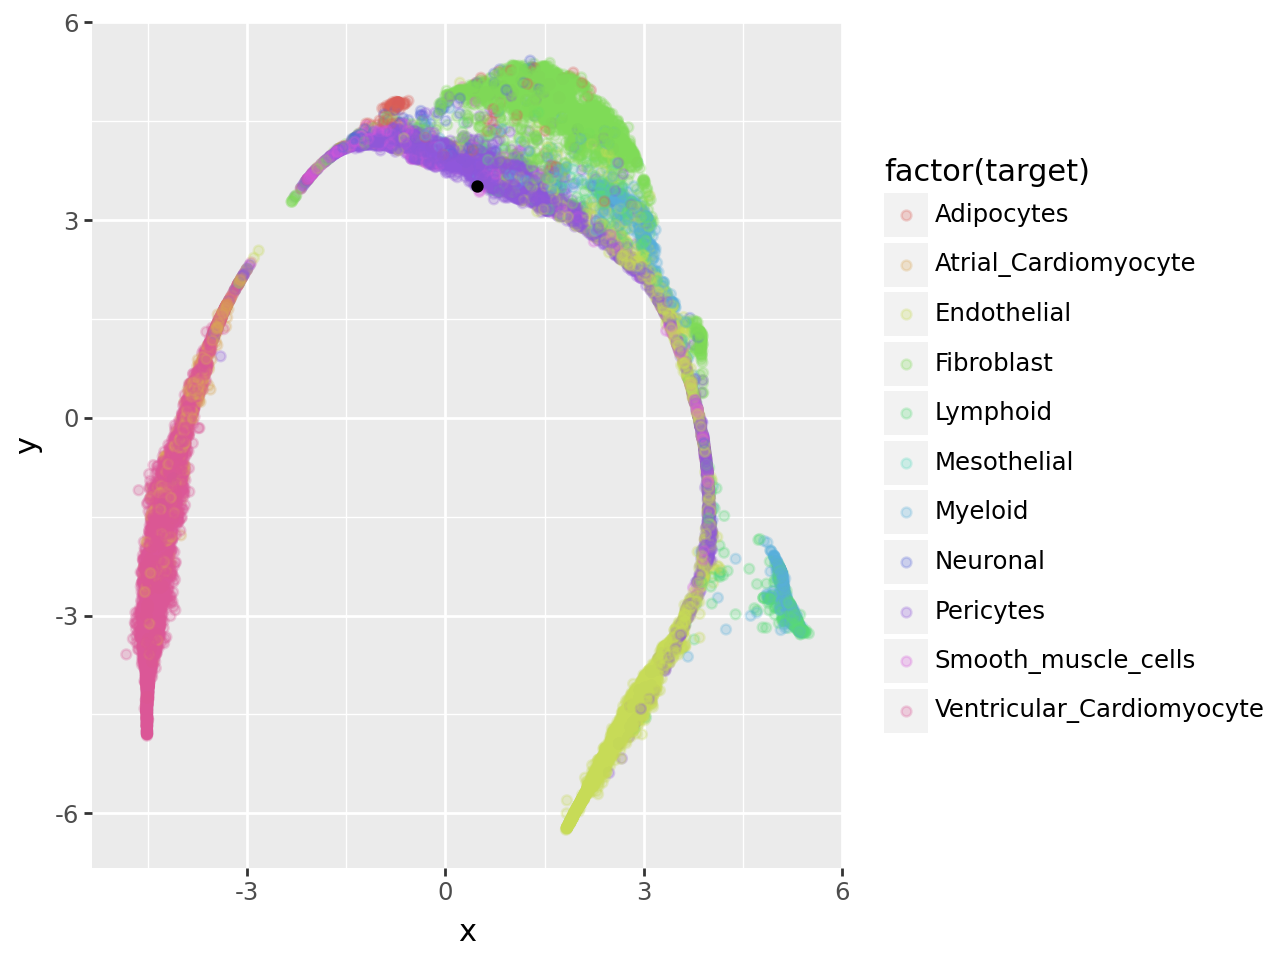

In [29]:
anchor_embedder = pyro_vmm.AnchorEmbedder(z_loc.detach())
centroids = anchor_embedder.increment(mix_locs.detach())

df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["target"] = cell_types_train.to_numpy()
df_mix = pd.DataFrame(centroids.numpy(), columns = ["x","y"])
p9.ggplot(df, p9.aes(x="x", y="y", color = "factor(target)")) + \
 p9.geom_point(alpha = 0.25) + p9.geom_point(data = df_mix, color = "black")

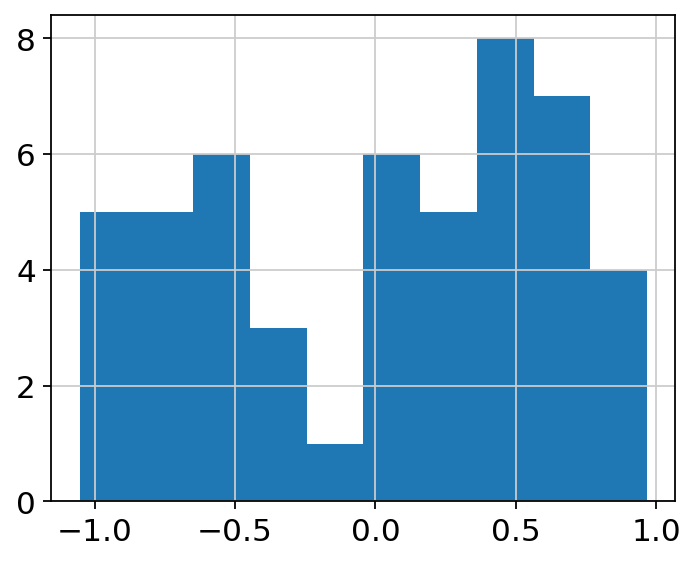

In [30]:
plt.hist(z_loc.mean(0).detach().cpu().numpy())
plt.show()

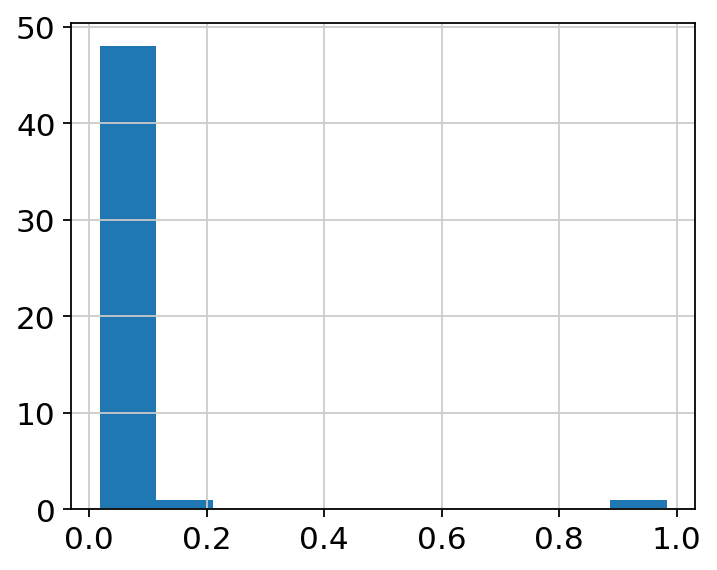

In [31]:
plt.hist(z_loc.std(0).detach().cpu().numpy())
plt.show()

## GMM

[epoch 000] average test loss: 402451.8248.1705
[epoch 005] average test loss: 13917.1151.9414
[epoch 010] average test loss: 9304.9660.9884
[epoch 015] average test loss: 8178.3951.0598
[epoch 020] average test loss: 7806.4214.5602
[epoch 025] average test loss: 7662.7063.6057
[epoch 030] average test loss: 7587.9705.2521
[epoch 035] average test loss: 7552.1136.9725
[epoch 040] average test loss: 7532.2774.9015
[epoch 045] average test loss: 7506.5719.0029
[epoch 050] average test loss: 7502.7858.3493
[epoch 055] average test loss: 7484.7052.6217
[epoch 060] average test loss: 7472.1891.1318
[epoch 065] average test loss: 7463.9976.5096
[epoch 070] average test loss: 7461.6021.8706
[epoch 075] average test loss: 7452.7544.1628
[epoch 080] average test loss: 7448.6280.9021
[epoch 085] average test loss: 7441.8327.6999
[epoch 090] average test loss: 7426.1301.3774
[epoch 095] average test loss: 7425.3164.4381
[epoch 100] average test loss: 7422.9174.6365
[epoch 105] average test loss: 

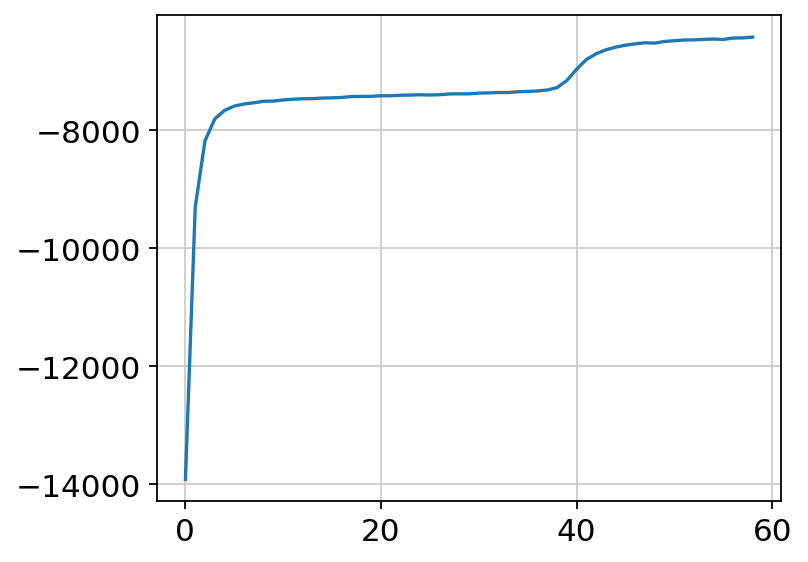

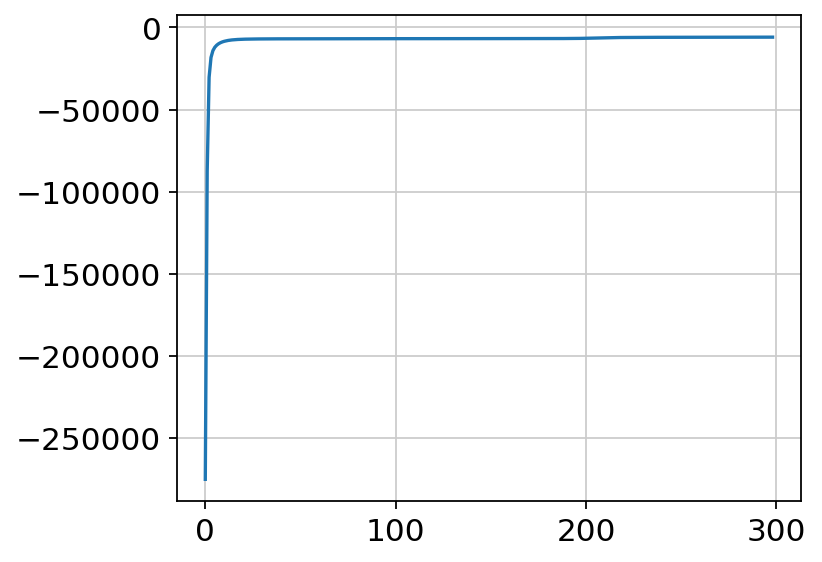

In [32]:
svi, vae_gmm = pyro_vmm.init_vae(X_train, train_loader, device, hidden_dim = 50, K = 100, z_dim = 50, z_prior = "gmm")

train_elbo, test_elbo = pyro_vmm.train_loop(svi, vae_gmm, train_loader, test_loader, device)
plt.plot(test_elbo[1:]); plt.show()
plt.plot(train_elbo[1:]); plt.show()

In [33]:
pyro_vmm.estimate_marginal_likelihood(vae_gmm, test_x_torch)

(-2820868.5002656253, -2819086.0)

Jul 30 10:35:19 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:35:19 2024 Building RP forest with 16 trees
Tue Jul 30 22:35:20 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:35:20 PM: Computing quadratic initialization.
Jul 30 10:35:25 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:35:25 2024 Building RP forest with 16 trees
Tue Jul 30 22:35:25 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:35:26 PM: Fitting a anchored embedding into R^2, for a graph with 14913 items and 15 edges.
Jul 30 10:35:26 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:35:26 PM: iteration 000 | distortion 2.116776 | residual norm 0.348579 | step length 10.527 | percent change 0.630419
Jul 30 10:35:26 PM: Converged in 008 iterations, with residual norm 2.85685e-

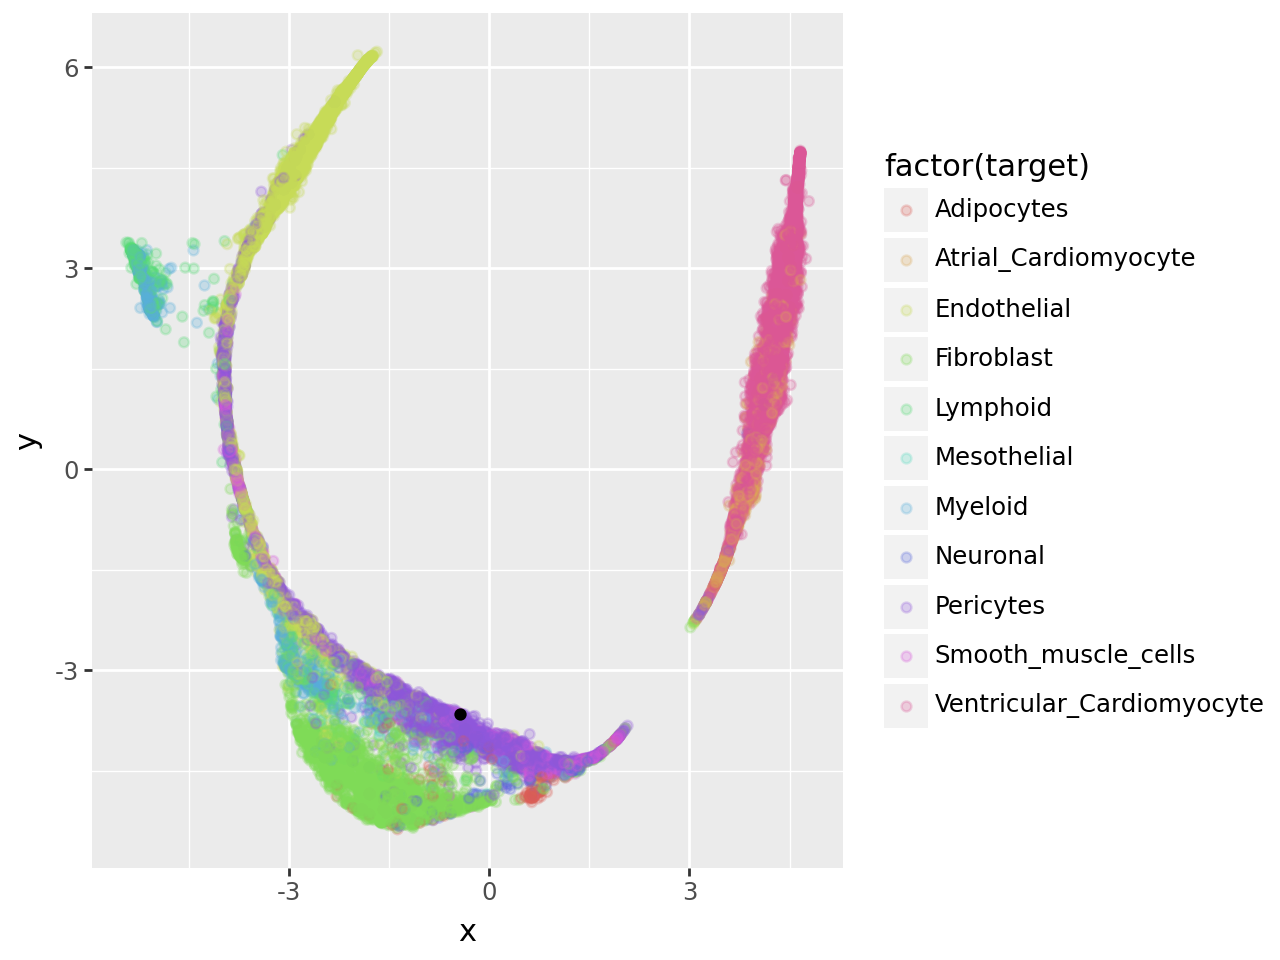

In [34]:
anchor_embedder = pyro_vmm.AnchorEmbedder(z_loc.detach())
centroids = anchor_embedder.increment(mix_locs.detach())

df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["target"] = cell_types_train.to_numpy()
df_mix = pd.DataFrame(centroids.numpy(), columns = ["x","y"])
p9.ggplot(df, p9.aes(x="x", y="y", color = "factor(target)")) + \
 p9.geom_point(alpha = 0.25) + p9.geom_point(data = df_mix, color = "black")

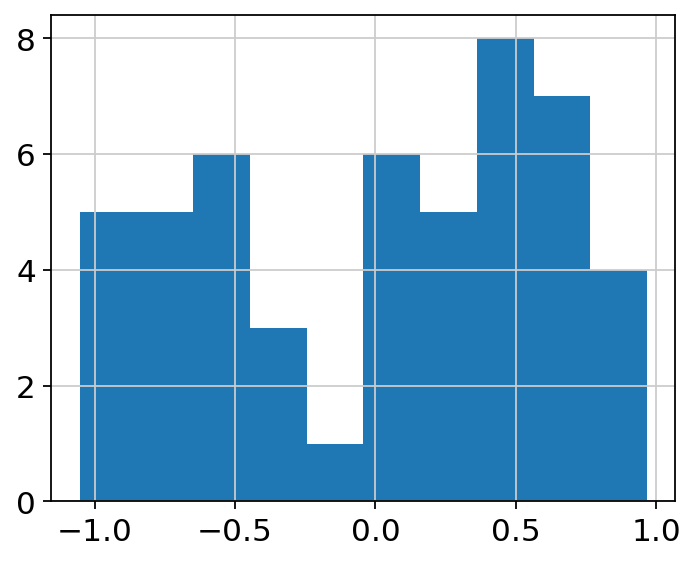

In [35]:
plt.hist(z_loc.mean(0).detach().cpu().numpy())
plt.show()

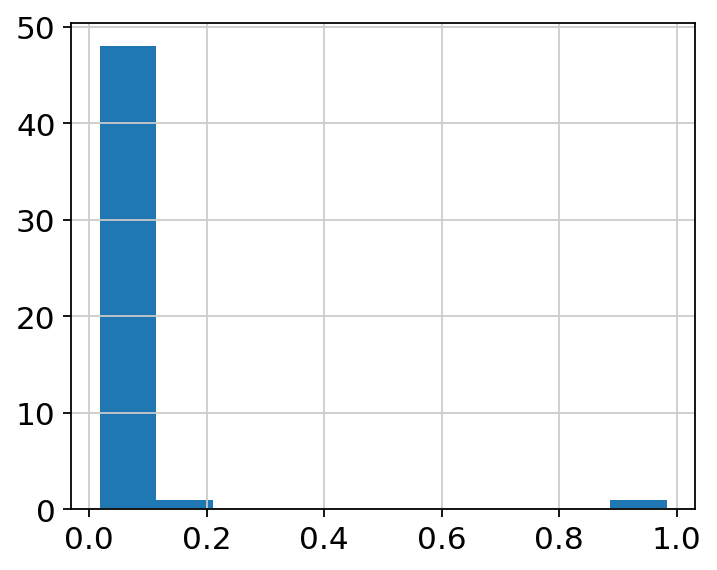

In [36]:
plt.hist(z_loc.std(0).detach().cpu().numpy())
plt.show()

## VMM

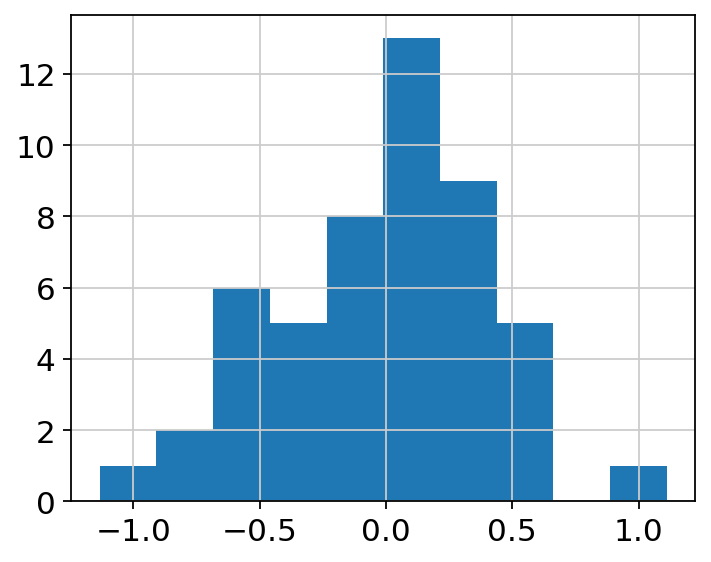

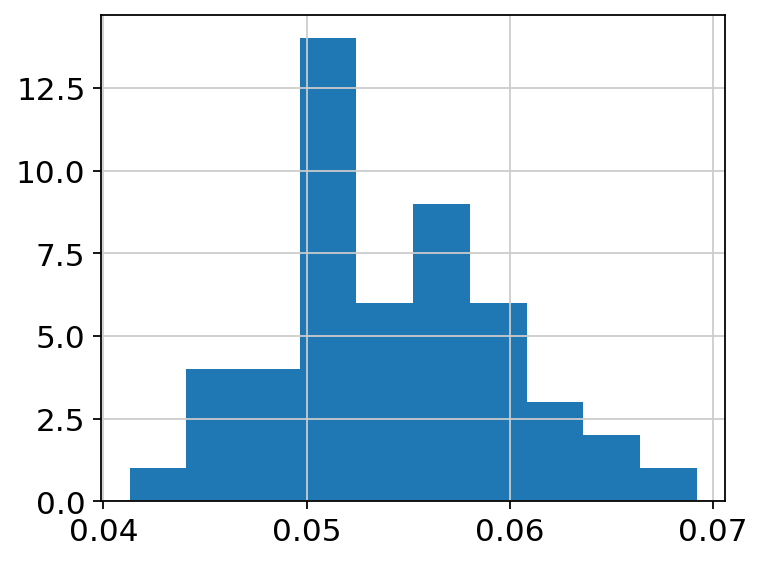

In [37]:
svi, vae_vmm = pyro_vmm.init_vae(X_train, train_loader, device, hidden_dim = 50, K = 100, z_dim = 50, z_prior = "vmm")

pseudo_loc, _ = vae_vmm.encoder(vae_vmm.auto_guide.pseudo_inputs)

plt.hist(pseudo_loc.mean(0).detach().cpu().numpy())
plt.show()
plt.hist(pseudo_loc.std(0).detach().cpu().numpy())
plt.show()

[epoch 000] average test loss: 358210.2204.8565
[epoch 005] average test loss: 13999.0107.8774
[epoch 010] average test loss: 9828.4214.3134
[epoch 015] average test loss: 8688.9786.3343
[epoch 020] average test loss: 8256.5352.5037
[epoch 025] average test loss: 7998.1610.6463
[epoch 030] average test loss: 7847.6012.2211
[epoch 035] average test loss: 7750.2465.1107
[epoch 040] average test loss: 7688.0155.0686
[epoch 045] average test loss: 7647.9099.7777
[epoch 050] average test loss: 7621.8015.0597
[epoch 055] average test loss: 7606.1124.1321
[epoch 060] average test loss: 7593.5843.3798
[epoch 065] average test loss: 7584.9594.1979
[epoch 070] average test loss: 7576.4212.9211
[epoch 075] average test loss: 7567.8750.8567
[epoch 080] average test loss: 7555.7279.7624
[epoch 085] average test loss: 7526.7936.7849
[epoch 090] average test loss: 7397.4520.1271
[epoch 095] average test loss: 7171.1361.3484
[epoch 100] average test loss: 7011.6169.6458
[epoch 105] average test loss: 

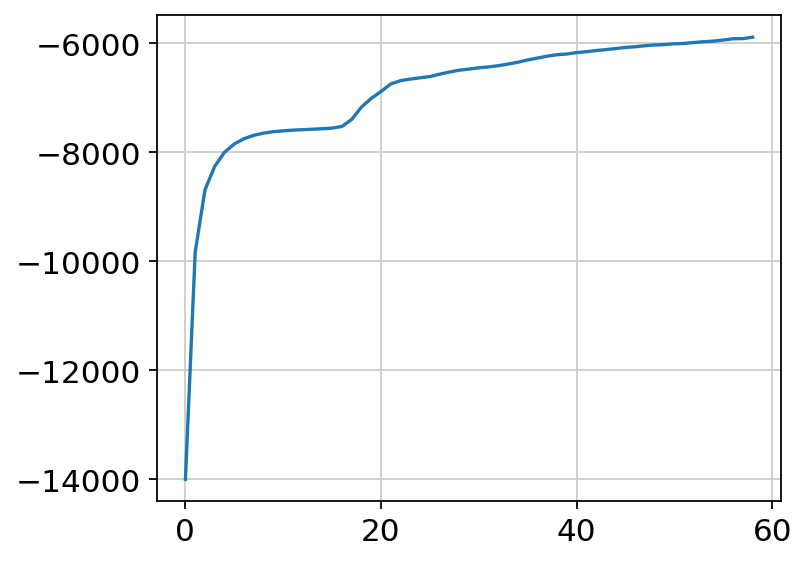

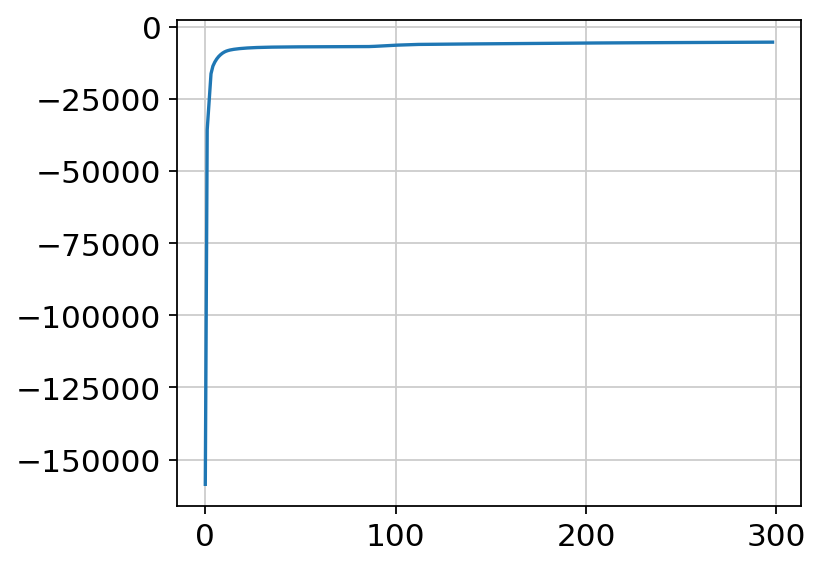

In [38]:
train_elbo, test_elbo = pyro_vmm.train_loop(svi, vae_vmm, train_loader, test_loader, device)
plt.plot(test_elbo[1:]); plt.show()
plt.plot(train_elbo[1:]); plt.show()

In [39]:
pyro_vmm.estimate_marginal_likelihood(vae_vmm, test_x_torch)

(-2688926.6127851577, -2687266.0)

Jul 30 10:40:33 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:40:33 2024 Building RP forest with 16 trees
Tue Jul 30 22:40:33 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Jul 30 10:40:33 PM: Computing quadratic initialization.
Jul 30 10:40:38 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:40:38 2024 Building RP forest with 16 trees
Tue Jul 30 22:40:38 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Jul 30 10:40:40 PM: Fitting a anchored embedding into R^2, for a graph with 15012 items and 2600 edges.
Jul 30 10:40:40 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:40:40 PM: iteration 000 | distortion 3.598306 | residual norm 0.0486625 | step length 550.45 | percent change 3.5366
Jul 30 10:40:40 PM: iteration 030 | distortion 0.177687 | residual norm 0.046292 | step length 0.2

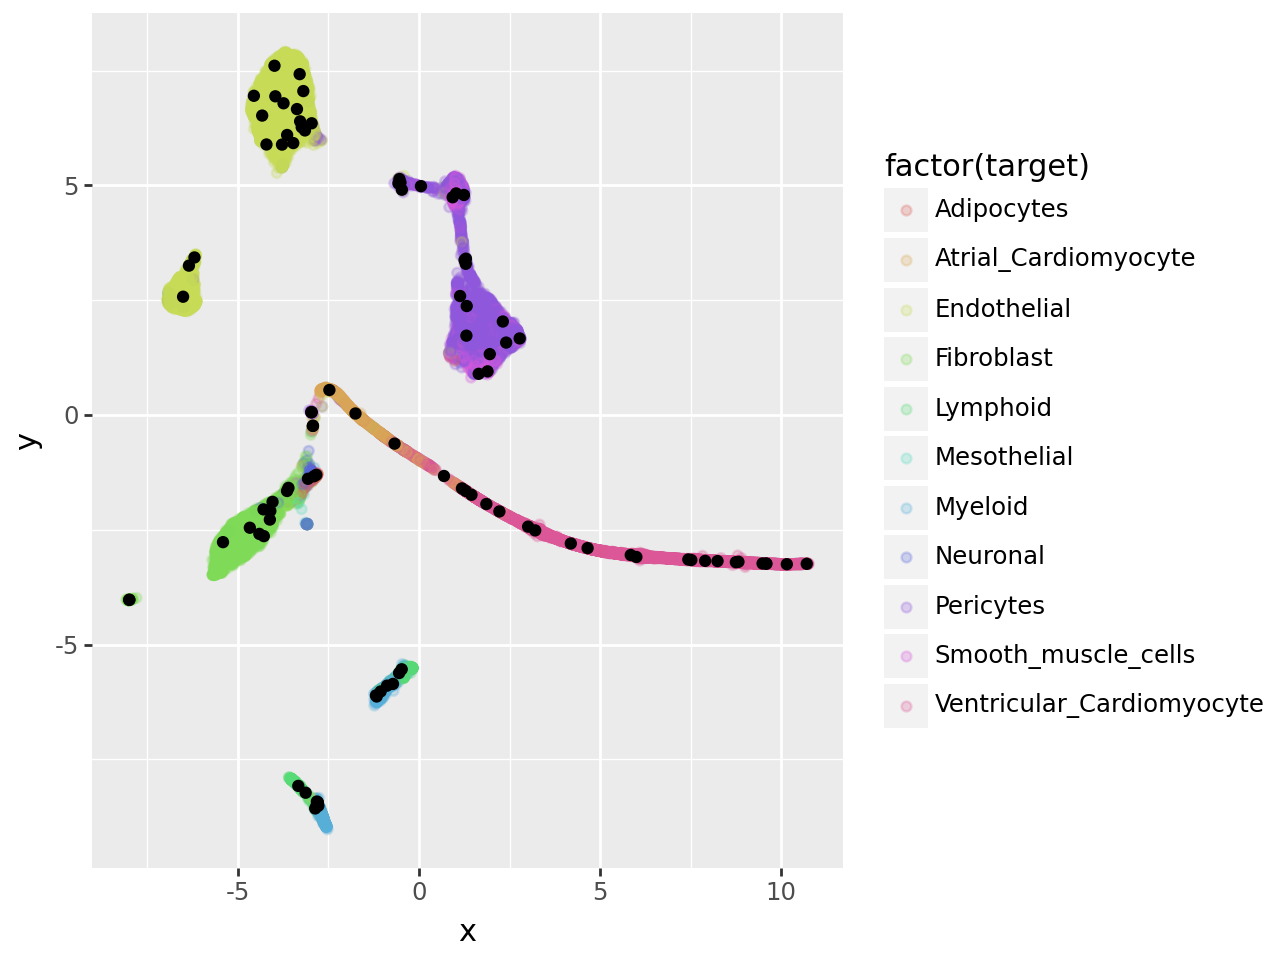

In [40]:
store = pyro.get_param_store()
mix_locs = vae_vmm.encoder(store["AutoDelta.pseudo_inputs"])[0]

z_loc, z_scale = vae_vmm.encoder(train_x_torch)

anchor_embedder = pyro_vmm.AnchorEmbedder(z_loc.detach())
centroids = anchor_embedder.increment(mix_locs.detach())

df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["target"] = cell_types_train.to_numpy()
df_mix = pd.DataFrame(centroids.numpy(), columns = ["x","y"])
p9.ggplot(df, p9.aes(x="x", y="y", color = "factor(target)")) + \
 p9.geom_point(alpha = 0.25) + p9.geom_point(data = df_mix, color = "black")

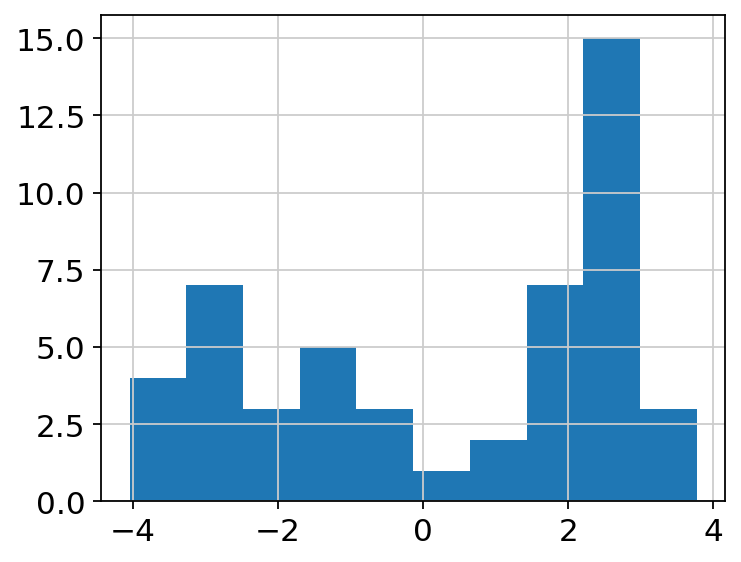

In [41]:
plt.hist(z_loc.mean(0).detach().cpu().numpy())
plt.show()

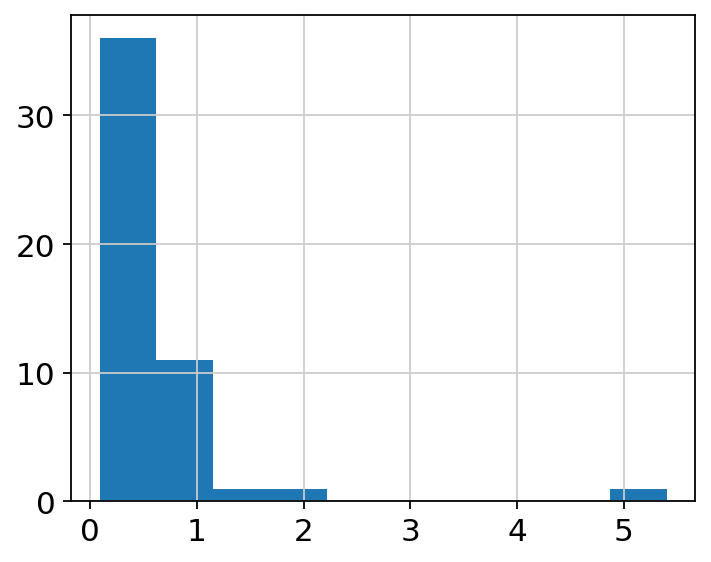

In [42]:
plt.hist(z_loc.std(0).detach().cpu().numpy())
plt.show()

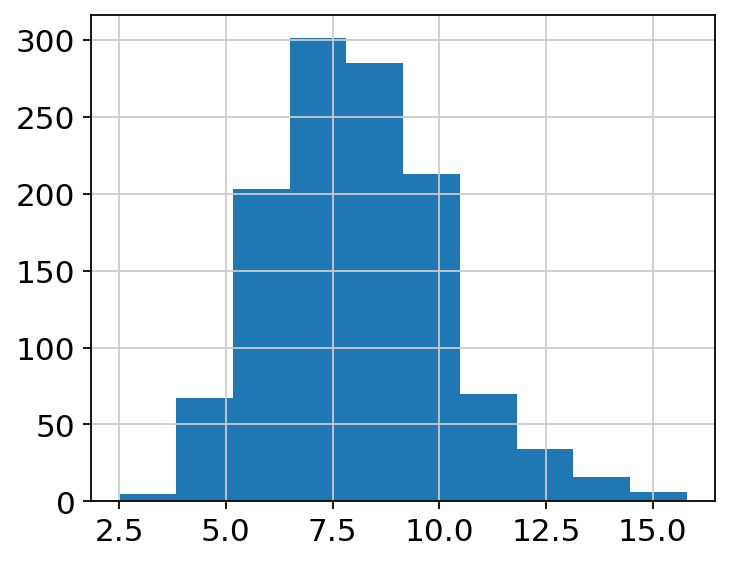

In [43]:
plt.hist(vae_vmm.auto_guide.theta.detach().cpu().numpy())
plt.show()

In [44]:
mix_scales = vae_vmm.auto_guide.mix_scales.detach().cpu()

(array([23., 16.,  8.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.11869141, 0.13357702, 0.14846262, 0.16334824, 0.17823385,
        0.19311947, 0.20800507, 0.22289069, 0.23777629, 0.25266191,
        0.26754752]),
 <BarContainer object of 10 artists>)

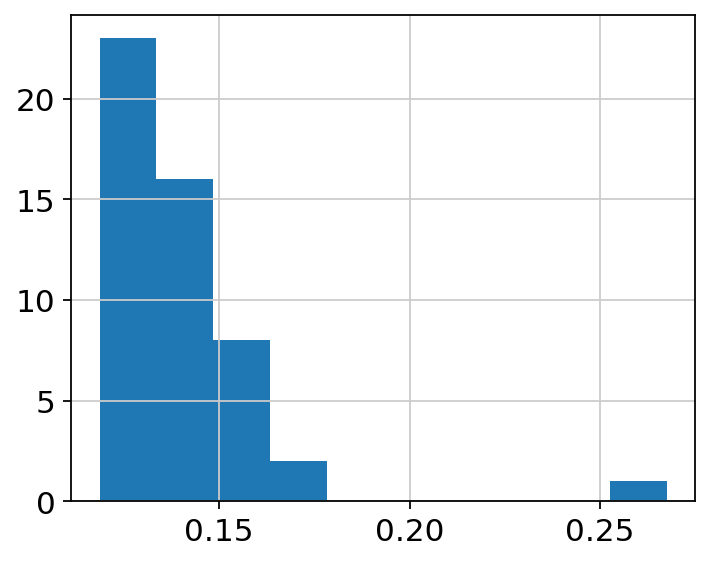

In [45]:
mix_scales.shape # K * z_dim
plt.hist(mix_scales.mean(0).numpy())

## VampPrior


[epoch 000] average test loss: 275426.5043.5709
[epoch 005] average test loss: 9644.4812.4960
[epoch 010] average test loss: 8498.0047.2606
[epoch 015] average test loss: 8075.6965.3088
[epoch 020] average test loss: 7867.3009.2774
[epoch 025] average test loss: 7747.4881.9122
[epoch 030] average test loss: 7585.7770.5449
[epoch 035] average test loss: 7268.3661.8656
[epoch 040] average test loss: 6977.3149.0911
[epoch 045] average test loss: 6823.4930.0118
[epoch 050] average test loss: 6734.9778.9459
[epoch 055] average test loss: 6655.9400.3566
[epoch 060] average test loss: 6580.0376.5674
[epoch 065] average test loss: 6501.3773.8756
[epoch 070] average test loss: 6421.2739.4501
[epoch 075] average test loss: 6347.1577.9286
[epoch 080] average test loss: 6284.0422.7266
[epoch 085] average test loss: 6223.0341.8043
[epoch 090] average test loss: 6167.3127.4888
[epoch 095] average test loss: 6123.4584.5293
[epoch 100] average test loss: 6092.0541.4106
[epoch 105] average test loss: 6

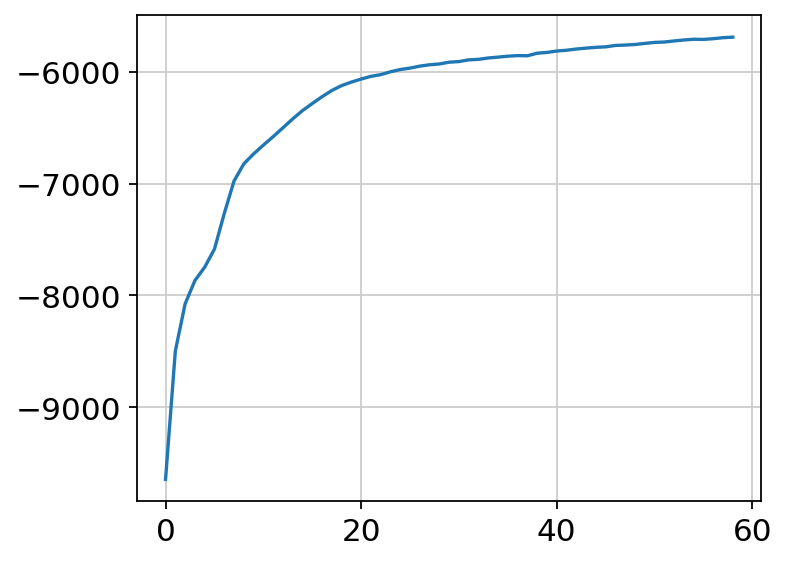

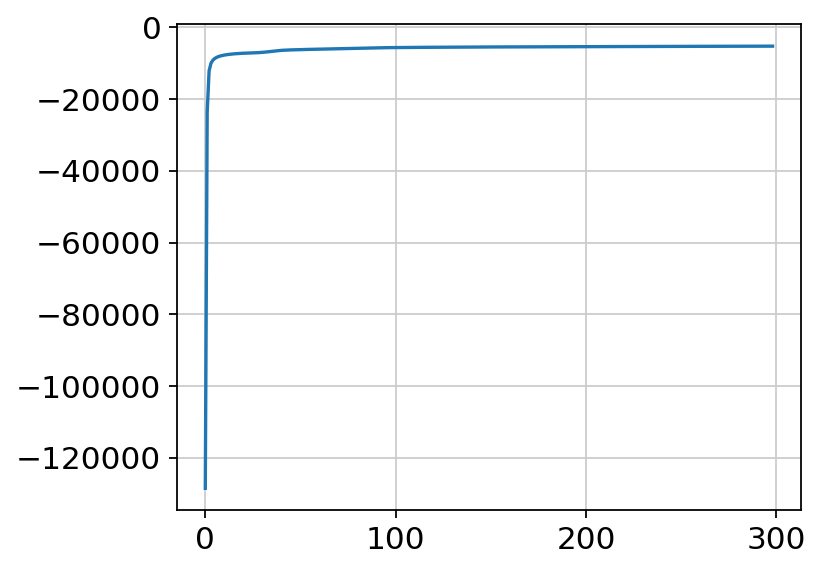

In [46]:
svi, vae_vampprior = pyro_vmm.init_vae(X_train, train_loader, device, hidden_dim = 50, K = 100, z_dim = 50, z_prior = "vampprior")

train_elbo, test_elbo = pyro_vmm.train_loop(svi, vae_vampprior, train_loader, test_loader, device)
plt.plot(test_elbo[1:]); plt.show()
plt.plot(train_elbo[1:]); plt.show()

In [47]:
pyro_vmm.estimate_marginal_likelihood(vae_vampprior, test_x_torch)

(-2585034.8435390643, -2583577.0)

Jul 30 10:45:38 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:45:38 2024 Building RP forest with 16 trees
Tue Jul 30 22:45:38 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Jul 30 10:45:39 PM: Computing quadratic initialization.
Jul 30 10:45:45 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:45:45 2024 Building RP forest with 16 trees
Tue Jul 30 22:45:45 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Jul 30 10:45:46 PM: Fitting a anchored embedding into R^2, for a graph with 15012 items and 914 edges.
Jul 30 10:45:46 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:45:46 PM: iteration 000 | distortion 1.917943 | residual norm 0.121534 | step length 67.9076 | percent change 1.11178
Jul 30 10:45:46 PM: iteration 030 | distortion 0.000486 | residual norm 0.00923653 | step length 1

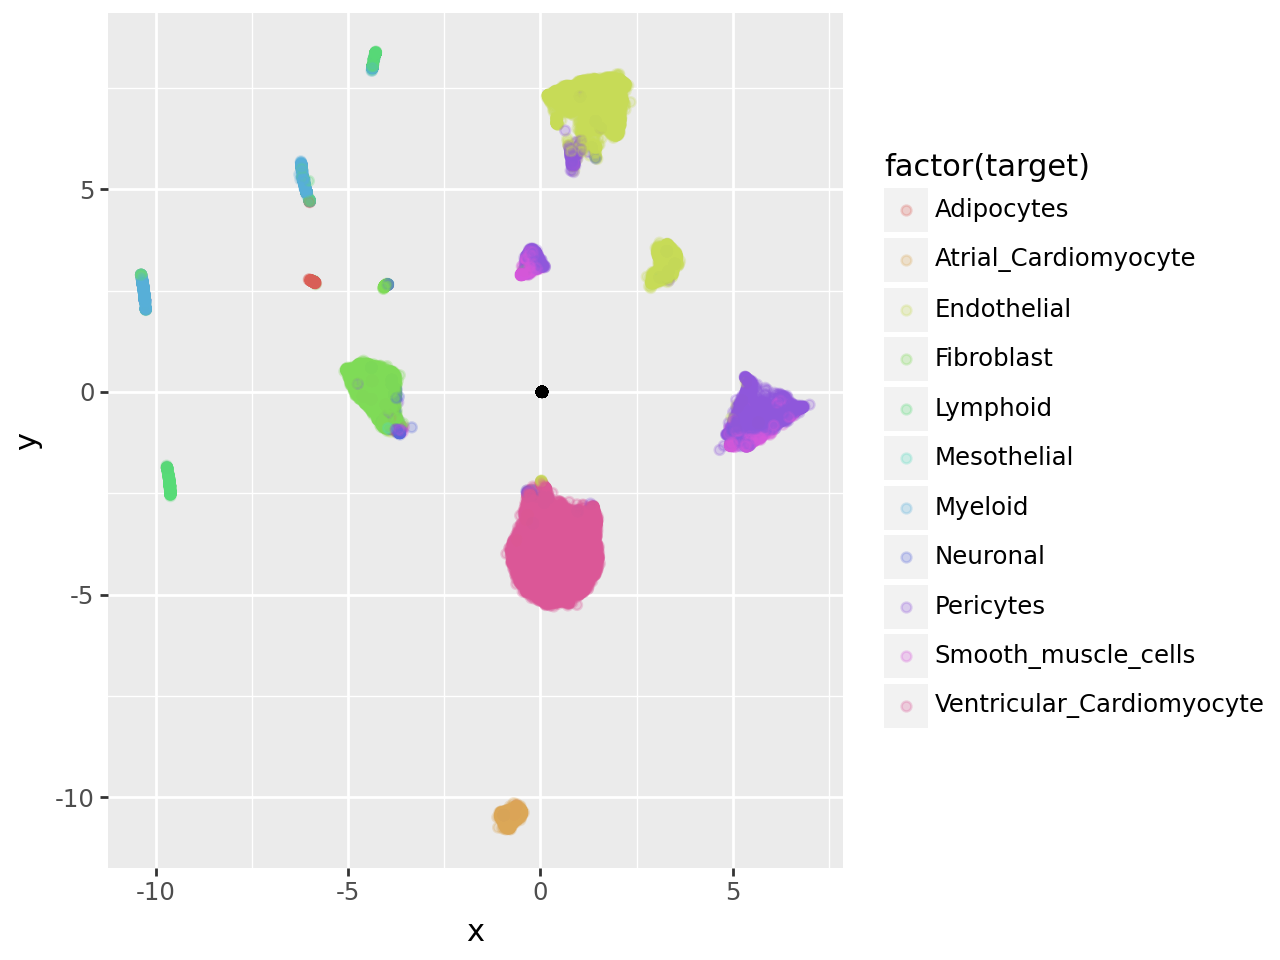

In [48]:
# Show centroids in latent space
z_loc, z_scale = vae_vampprior.encoder(train_x_torch)

anchor_embedder = pyro_vmm.AnchorEmbedder(z_loc.detach())
centroids = anchor_embedder.increment(mix_locs.detach())

df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["target"] = cell_types_train.to_numpy()
df_mix = pd.DataFrame(centroids.numpy(), columns = ["x","y"])
p9.ggplot(df, p9.aes(x="x", y="y", color = "factor(target)")) + \
 p9.geom_point(alpha = 0.25) + p9.geom_point(data = df_mix, color = "black")

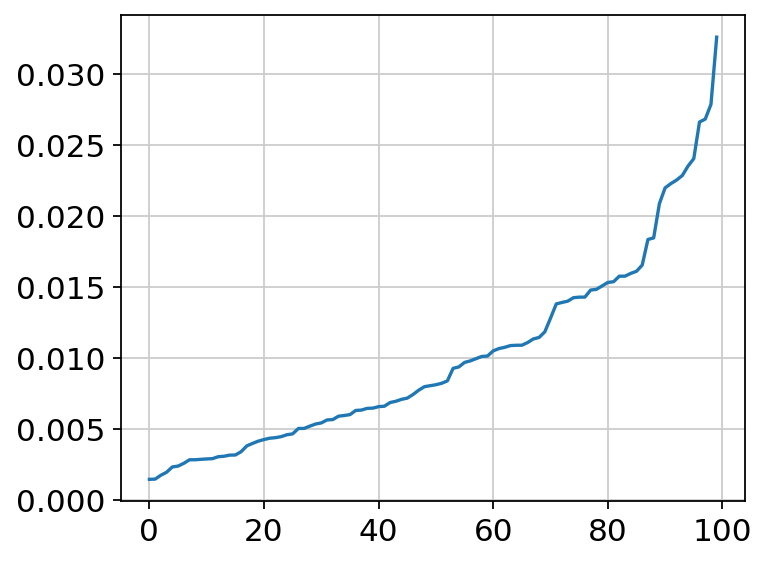

In [49]:
plt.plot(vae_vampprior.auto_guide.pi.sort().values.detach().cpu().numpy())

Jul 30 10:45:48 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:45:48 2024 Building RP forest with 17 trees
Tue Jul 30 22:45:48 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:45:51 PM: Fitting a anchored embedding into R^2, for a graph with 17912 items and 58799 edges.
Jul 30 10:45:51 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:45:51 PM: iteration 000 | distortion 1.978783 | residual norm 0.00414498 | step length 52841.3 | percent change 29.3523
Jul 30 10:45:51 PM: iteration 030 | distortion 0.125880 | residual norm 0.00275271 | step length 1 | percent change 1.12286
Jul 30 10:45:51 PM: iteration 060 | distortion 0.089044 | residual norm 0.00065252 | step length 1 | percent change 0.179456
Jul 30 10:45:51 PM: iteration 090 | distortion 0.087324 | residual norm 0.000192558 | step length 1.74749 | percent change 0.243795
Jul 30 10:45:51 PM: i

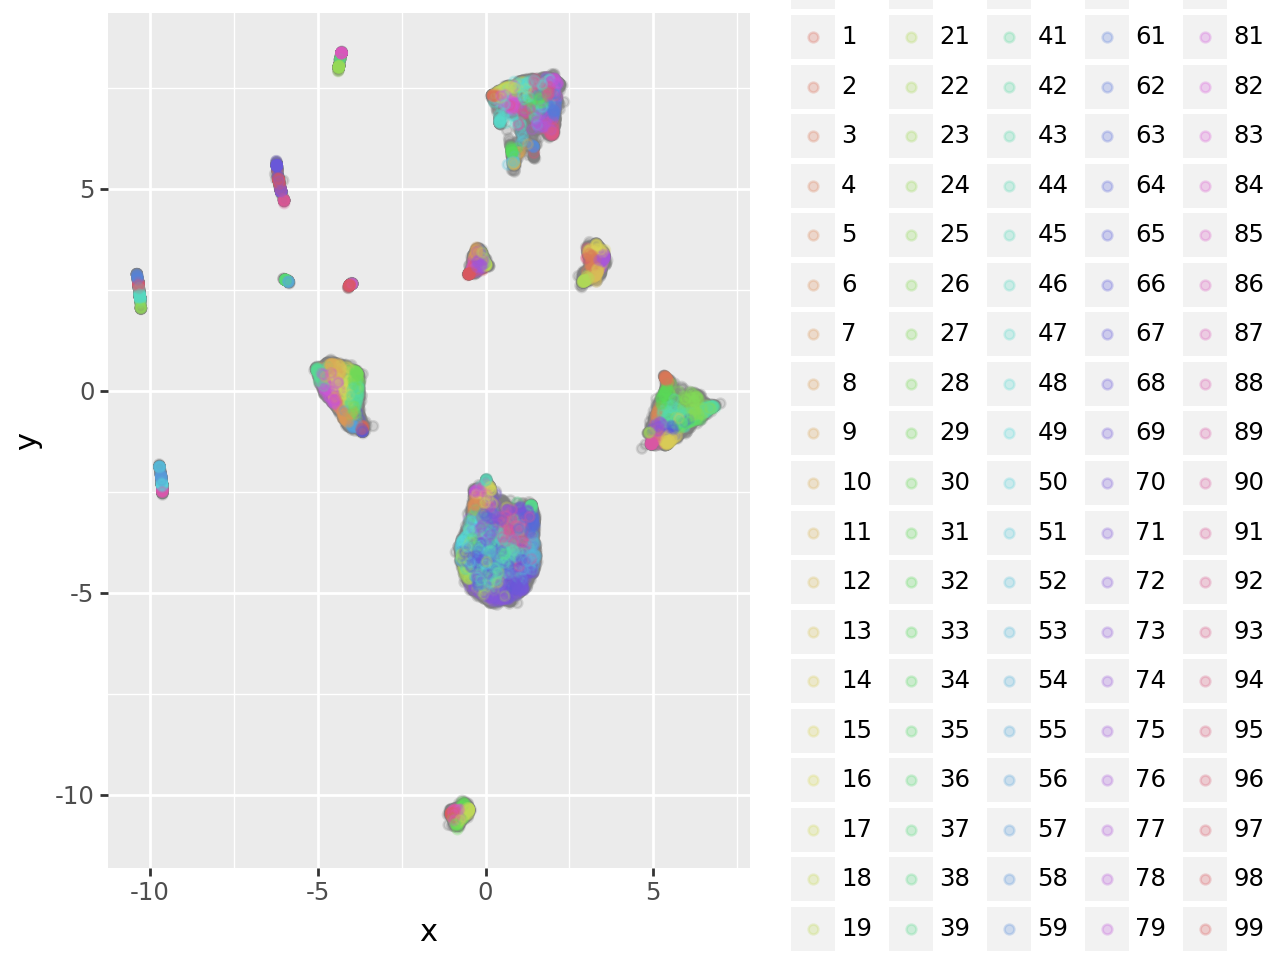

In [50]:
# show samples from the model on top of the actual data (in latent space) 
mix_sample, samples = vae_vampprior.gmm_sample(3000)

z_samples = anchor_embedder.increment(samples.detach())

df_mix = pd.DataFrame(z_samples.numpy(), columns = ["x","y"])
df_mix["mix"] = mix_sample.cpu().numpy()
p9.ggplot(df, p9.aes(x="x", y="y")) + \
 p9.geom_point(color = "gray", alpha = 0.25) + p9.geom_point(data = df_mix, mapping = p9.aes(color = "factor(mix)"), alpha = 0.25)

## Initialize VMM with VampPrior

In [51]:
pyro.clear_param_store()

pyro.set_rng_seed(42)

vae_vmm = pyro_vmm.VAE(
    total_N = X_train.shape[0],
    obs_dim = X_train.shape[1],
    norm_count_factor = 1e4,
    hidden_dim = 50, K = 100, z_dim = 50,
    z_prior = "vmm"
    ).to(device)

optimizer = Adam({"lr": 1e-3})

svi = pyro_vmm.SVI(vae_vmm.model, vae_vmm.guide, optimizer, loss=Trace_ELBO())

for x in train_loader: # force param init
    x = x.to(device)
    svi.evaluate_loss(x)
    break

# set VMM params to vampprior fit
vae_vmm.auto_guide.pseudo_inputs = vae_vampprior.auto_guide.pseudo_inputs
vae_vmm.auto_guide.pi = vae_vampprior.auto_guide.pi
vae_vmm.encoder = vae_vampprior.encoder
vae_vmm.decoder = vae_vampprior.decoder

# init mix_scales to a constant (better choices?) 
vae_vmm.auto_guide.mix_scales = torch.full_like(vae_vmm.auto_guide.mix_scales_unconstrained, 0.1)

optimizer = Adam({"lr": 1e-2})
svi = SVI(vae_vmm.model, vae_vmm.guide, optimizer, loss=Trace_ELBO())


[epoch 000] average test loss: 11710.9195.9773
[epoch 005] average test loss: 7092.5024.2445
[epoch 010] average test loss: 5915.6810.7487
[epoch 015] average test loss: 5615.4761.2947
[epoch 020] average test loss: 5503.6231.7918
[epoch 025] average test loss: 5455.0615.7198
[epoch 030] average test loss: 5432.6337.0742
[epoch 035] average test loss: 5420.8510.6952
[epoch 040] average test loss: 5413.1018.8303
[epoch 045] average test loss: 5409.8904.9004
[epoch 050] average test loss: 5406.1786.2589
[epoch 055] average test loss: 5404.4988.2762
[epoch 060] average test loss: 5404.4838.1291
[epoch 065] average test loss: 5400.9431.5004
[epoch 070] average test loss: 5399.1132.6886
[epoch 075] average test loss: 5398.8326.8195
[epoch 080] average test loss: 5395.3660.8875
[epoch 085] average test loss: 5396.0211.0481
[epoch 090] average test loss: 5391.1974.1592
[epoch 095] average test loss: 5392.0399.2775
[epoch 100] average test loss: 5389.6525.9219
[epoch 105] average test loss: 53

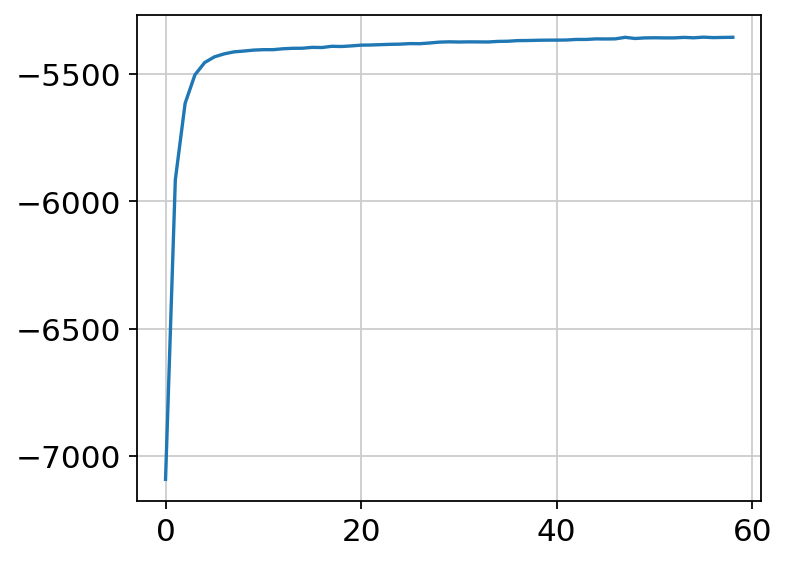

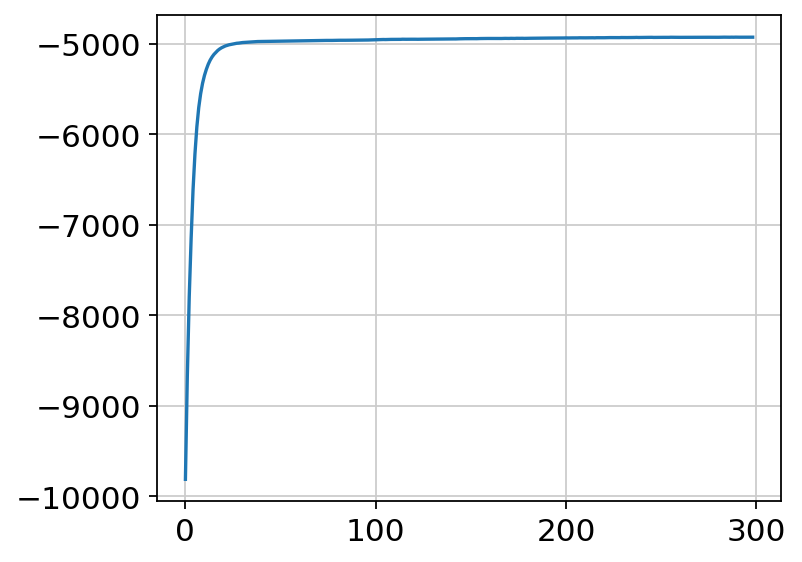

In [52]:
train_elbo, test_elbo = pyro_vmm.train_loop(svi, vae_vmm, train_loader, test_loader, device, file_suffix = "vp_init_vmm")
plt.plot(test_elbo[1:]); plt.show()
plt.plot(train_elbo[1:]); plt.show()

In [53]:
pyro_vmm.estimate_marginal_likelihood(vae_vmm, test_x_torch)

(-1999458.8690468753, -1998083.5)

Jul 30 10:50:44 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:50:44 2024 Building RP forest with 16 trees
Tue Jul 30 22:50:44 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Jul 30 10:50:45 PM: Computing quadratic initialization.
Jul 30 10:50:49 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:50:49 2024 Building RP forest with 16 trees
Tue Jul 30 22:50:49 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Jul 30 10:50:51 PM: Fitting a anchored embedding into R^2, for a graph with 15012 items and 1944 edges.
Jul 30 10:50:51 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:50:51 PM: iteration 000 | distortion 2.944519 | residual norm 0.0613873 | step length 550.5 | percent change 4.73673
Jul 30 10:50:51 PM: iteration 030 | distortion 0.291680 | residual norm 0.0243765 | step length 1 

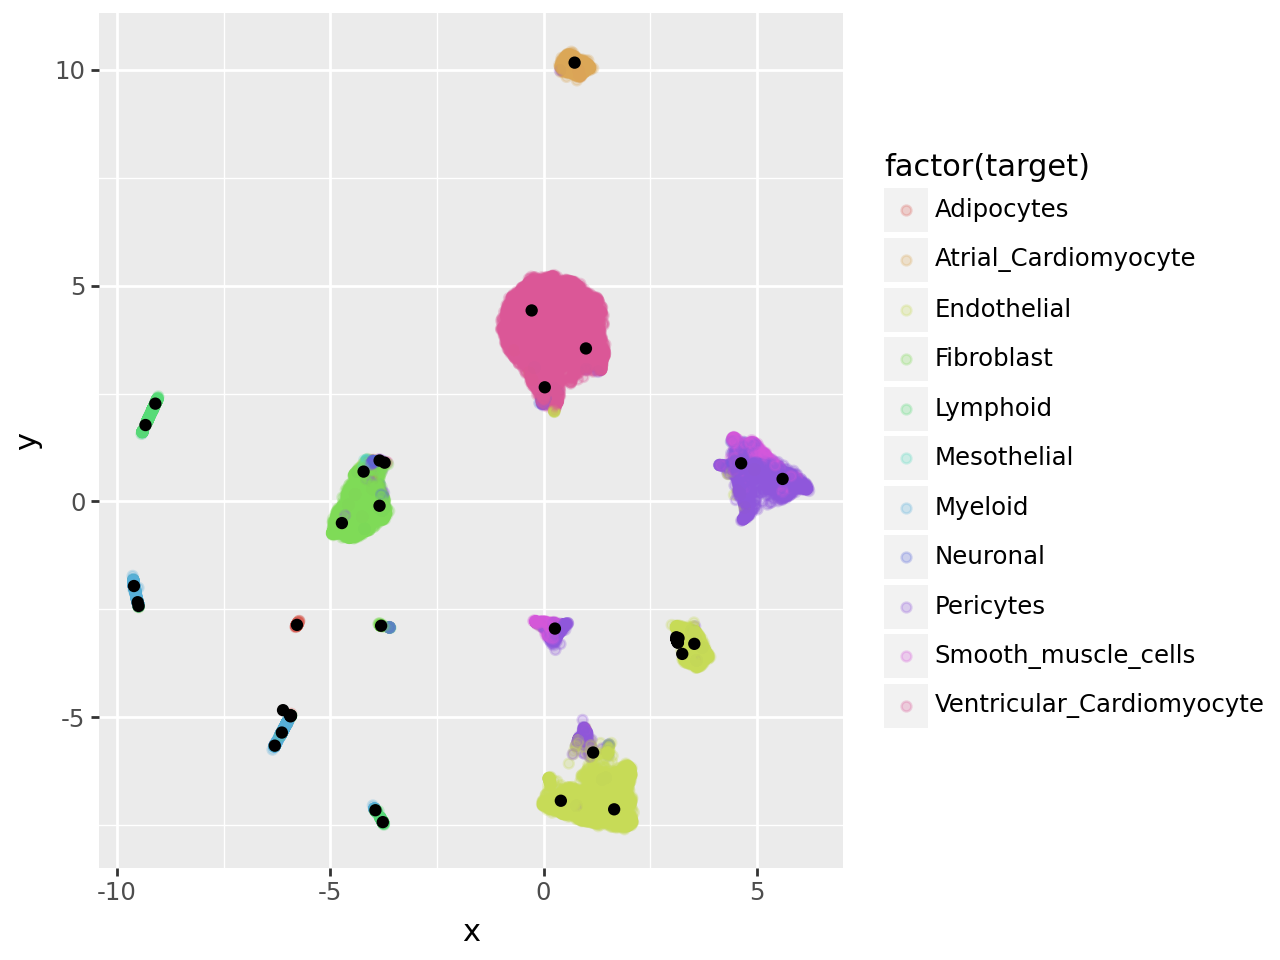

In [54]:
store = pyro.get_param_store()
mix_locs = vae_vmm.encoder(store["AutoDelta.pseudo_inputs"])[0]

z_loc, z_scale = vae_vmm.encoder(train_x_torch)

anchor_embedder = pyro_vmm.AnchorEmbedder(z_loc.detach())
centroids = anchor_embedder.increment(mix_locs.detach())

df = pd.DataFrame(anchor_embedder.embedding.numpy(), columns = ["x","y"])
df["target"] = cell_types_train.to_numpy()
df_mix = pd.DataFrame(centroids.numpy(), columns = ["x","y"])
p9.ggplot(df, p9.aes(x="x", y="y", color = "factor(target)")) + \
 p9.geom_point(alpha = 0.25) + p9.geom_point(data = df_mix, color = "black")

Jul 30 10:50:52 PM: Computing 15-nearest neighbors, with max_distance=None
Tue Jul 30 22:50:52 2024 Building RP forest with 17 trees
Tue Jul 30 22:50:52 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Jul 30 10:50:54 PM: Fitting a anchored embedding into R^2, for a graph with 17912 items and 58718 edges.
Jul 30 10:50:54 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Jul 30 10:50:54 PM: iteration 000 | distortion 1.976441 | residual norm 0.00481525 | step length 7.9311 | percent change 0.00532295
Jul 30 10:50:55 PM: iteration 030 | distortion 0.139652 | residual norm 0.003351 | step length 1 | percent change 0.695817
Jul 30 10:50:55 PM: iteration 060 | distortion 0.100451 | residual norm 0.000572284 | step length 1 | percent change 0.118253
Jul 30 10:50:55 PM: iteration 090 | distortion 0.095839 | residual norm 0.000329229 | step length 1 | percent change 0.29289
Jul 30 10:50:55 PM: iterat

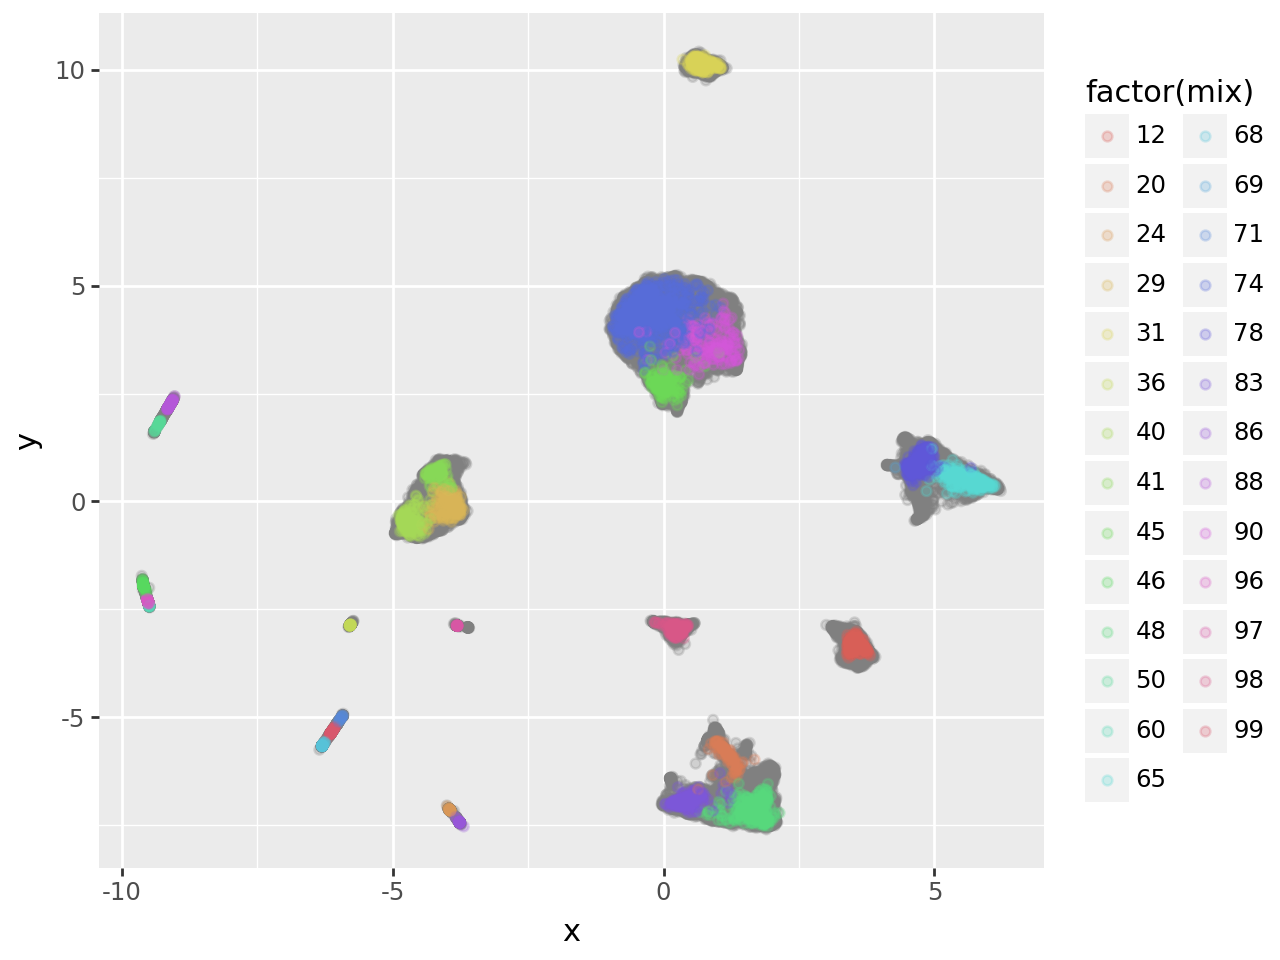

In [55]:
# show samples from the model on top of the actual data (in latent space) 
mix_sample, samples = vae_vmm.gmm_sample(3000)

z_samples = anchor_embedder.increment(samples.detach())

df_mix = pd.DataFrame(z_samples.numpy(), columns = ["x","y"])
df_mix["mix"] = mix_sample.cpu().numpy()
p9.ggplot(df, p9.aes(x="x", y="y")) + \
 p9.geom_point(color = "gray", alpha = 0.25) + p9.geom_point(data = df_mix, mapping = p9.aes(color = "factor(mix)"), alpha = 0.25)

In [57]:
vae_vmm.auto_guide.mix_scales # end up being quite a bit bigger than the 0.1 they are init to

tensor([[0.3000, 0.3001, 0.2768,  ..., 0.2732, 0.2501, 0.2760],
        [0.3000, 0.3000, 0.2948,  ..., 0.2942, 0.2513, 0.2961],
        [0.2998, 0.2999, 0.2662,  ..., 0.2723, 0.2675, 0.2984],
        ...,
        [0.2794, 0.3546, 0.6744,  ..., 0.5067, 1.0031, 0.2620],
        [0.3178, 0.3138, 0.7706,  ..., 1.1701, 1.6055, 0.3720],
        [0.3411, 0.3071, 0.7292,  ..., 0.5386, 1.0111, 0.4380]],
       device='cuda:0', grad_fn=<AddBackward0>)